In [1]:
import numpy as np
from typing import List, Dict, Any, Union, Optional, Tuple
import json

In [2]:
class VIKOR:
    """Универсальный класс для метода VIKOR с поддержкой различных модификаций"""
    
    def __init__(self, 
                 matrix: np.ndarray,
                 modification: str = 'crisp',
                 weights: Union[List[float], np.ndarray] = None,
                 criteria_types: Union[List[int], List[bool]] = None,
                 v: float = 0.5,
                 tradeoff_index: int = 0,
                 tr_custom_values: Optional[np.ndarray] = None,
                 **kwargs):
        """
        Инициализация объекта VIKOR
        
        Parameters:
        -----------
        matrix : np.ndarray
            Матрица решений:
            - crisp: shape (m, n)
            - interval: shape (m, n, 2) - [нижняя, верхняя граница]
            - fuzzy: shape (m, n, 3) - [левая, средняя, правая граница]
        
        modification : str
            Модификация метода: 'crisp', 'interval', 'fuzzy'
        
        weights : Union[List[float], np.ndarray]
            Веса критериев:
            - crisp: список длины n
            - interval: список длины n
            - fuzzy: массив формы (n, 3) или список длины n (преобразуется в (n,3))
        
        criteria_types : Union[List[int], List[bool]]
            Типы критериев:
            - crisp/interval: список с 1 (benefit) или -1 (cost)
            - fuzzy: список с True (benefit) или False (cost)
        
        v : float
            Коэффициент компромисса (0 <= v <= 1)
        
        tradeoff_index : int
            Индекс критерия для уступки (используется в fuzzy)
        
        tr_custom_values : Optional[np.ndarray]
            Пользовательские значения уступок (используется в fuzzy)
        
        **kwargs : дополнительные параметры
        """
        self.matrix = matrix
        self.modification = modification.lower()
        self.v = v
        self.tradeoff_index = tradeoff_index
        self.tr_custom_values = tr_custom_values
        self.kwargs = kwargs
        
        # Парсинг и валидация входных данных
        self._parse_and_validate_input(weights, criteria_types)
        
        # Результаты
        self.results = {}
        
    def _parse_and_validate_input(self, weights, criteria_types):
        """Парсинг и валидация входных данных"""
        
        # Проверка модификации
        valid_modifications = ['crisp', 'interval', 'fuzzy']
        if self.modification not in valid_modifications:
            raise ValueError(f"Неизвестная модификация: {self.modification}. "
                           f"Допустимые значения: {valid_modifications}")
        
        # Проверка матрицы
        if not isinstance(self.matrix, np.ndarray):
            self.matrix = np.array(self.matrix)
        
        # Определение размеров
        if self.modification == 'crisp':
            if self.matrix.ndim != 2:
                raise ValueError(f"Для классического метода VIKOR матрица должна быть 2D, получен {self.matrix.ndim}D")
            self.m, self.n = self.matrix.shape
            self.depth = 1
        elif self.modification == 'interval':
            if self.matrix.ndim != 3 or self.matrix.shape[2] != 2:
                raise ValueError(f"Для интервальной модификации матрица должна быть 3D с shape[2]==2, "
                               f"получен {self.matrix.shape}")
            self.m, self.n, self.depth = self.matrix.shape
        elif self.modification == 'fuzzy':
            if self.matrix.ndim != 3 or self.matrix.shape[2] != 3:
                raise ValueError(f"Для нечеткой модификации матрица должна быть 3D с shape[2]==3, "
                               f"получен {self.matrix.shape}")
            self.m, self.n, self.depth = self.matrix.shape
        
        # Проверка весов
        if weights is None:
            # Веса по умолчанию: равные
            if self.modification == 'fuzzy':
                self.weights = np.ones((self.n, 3)) / self.n
            else:
                self.weights = np.ones(self.n) / self.n
        else:
            weights = np.array(weights)
            
            if self.modification == 'fuzzy':
                if weights.ndim == 1:
                    # Преобразование в треугольные нечеткие числа
                    w_expanded = []
                    for w in weights:
                        w_expanded.append([w, w, w])
                    self.weights = np.array(w_expanded)
                elif weights.shape == (self.n, 3):
                    self.weights = weights
                else:
                    raise ValueError(f"Для fuzzy модификации weights должен быть shape ({self.n},) или ({self.n}, 3), "
                                   f"получен {weights.shape}")
            else:
                if weights.shape != (self.n,):
                    raise ValueError(f"Для {self.modification} модификации weights должен быть длины {self.n}, "
                                   f"получен {weights.shape}")
                self.weights = weights
                
                # Нормализация весов
                if self.modification != 'fuzzy':
                    self.weights = self.weights / np.sum(self.weights)
        
        # Проверка типов критериев
        if criteria_types is None:
            if self.modification == 'fuzzy':
                self.criteria_types = [True] * self.n
            else:
                self.criteria_types = [1] * self.n
        else:
            self.criteria_types = list(criteria_types)
            
            if len(self.criteria_types) != self.n:
                raise ValueError(f"criteria_types должен быть длины {self.n}, получен {len(self.criteria_types)}")
            
            # Преобразование типов для fuzzy
            if self.modification == 'fuzzy':
                # Преобразование 1/-1 в True/False
                if all(isinstance(t, (int, float)) for t in self.criteria_types):
                    self.criteria_types = [bool(t == 1) for t in self.criteria_types]
            else:
                # Преобразование bool в 1/-1
                if all(isinstance(t, bool) for t in self.criteria_types):
                    self.criteria_types = [1 if t else -1 for t in self.criteria_types]
        
        # Проверка v
        if not 0 <= self.v <= 1:
            raise ValueError(f"v должен быть в диапазоне [0, 1], получен {self.v}")
        
        # Проверка tradeoff_index для fuzzy
        if self.modification == 'fuzzy':
            if not 0 <= self.tradeoff_index < self.n:
                raise ValueError(f"tradeoff_index должен быть в диапазоне [0, {self.n-1}], получен {self.tradeoff_index}")
            
            # Преобразование tr_custom_values в numpy array если нужно
            if self.tr_custom_values is not None and not isinstance(self.tr_custom_values, np.ndarray):
                self.tr_custom_values = np.array(self.tr_custom_values)
    
    def calculate(self) -> Dict[str, Any]:
        """Выполнение расчета VIKOR"""
        
        if self.modification == 'crisp':
            return self._calculate_crisp()
        elif self.modification == 'interval':
            return self._calculate_interval()
        elif self.modification == 'fuzzy':
            return self._calculate_fuzzy()
    
    def _calculate_crisp(self) -> Dict[str, Any]:
        """Оригинальный (четкий) метод VIKOR"""
        
        # 1) Определение идеальных и антиидеальных значений
        f_star = np.zeros(self.n)
        f_minus = np.zeros(self.n)
        
        for j in range(self.n):
            if self.criteria_types[j] == 1:  # benefit
                f_star[j] = np.max(self.matrix[:, j])
                f_minus[j] = np.min(self.matrix[:, j])
            else:  # cost
                f_star[j] = np.min(self.matrix[:, j])
                f_minus[j] = np.max(self.matrix[:, j])
        
        # 2) Вычисление нормализованных разрывов
        D = np.zeros((self.m, self.n))
        for i in range(self.m):
            for j in range(self.n):
                denom = f_star[j] - f_minus[j]
                if abs(denom) > 1e-12:
                    D[i, j] = (f_star[j] - self.matrix[i, j]) / denom
                else:
                    D[i, j] = 0.0
                D[i, j] = np.clip(D[i, j], 0.0, 1.0)
        
        # 3) Вычисление S и R
        S = np.zeros(self.m)
        R = np.zeros(self.m)
        
        for i in range(self.m):
            S[i] = np.sum(self.weights * D[i, :])
            R[i] = np.max(self.weights * D[i, :]) if self.n > 0 else 0.0
        
        # 4) Вычисление S*, S-, R*, R-
        S_star = np.min(S)
        S_minus = np.max(S)
        R_star = np.min(R)
        R_minus = np.max(R)
        
        # 5) Вычисление Q
        Q = np.zeros(self.m)
        for i in range(self.m):
            term_S = (S[i] - S_star) / (S_minus - S_star) if abs(S_minus - S_star) > 1e-12 else 0.0
            term_R = (R[i] - R_star) / (R_minus - R_star) if abs(R_minus - R_star) > 1e-12 else 0.0
            Q[i] = self.v * term_S + (1.0 - self.v) * term_R
            Q[i] = np.clip(Q[i], 0.0, 1.0)
        
        # 6) Ранжирование
        ranking = np.argsort(Q)
        
        # 7) Проверка условий приемлемости
        DQ = 1.0 / (self.m - 1) if self.m > 1 else 1.0
        condition1 = (len(Q) > 1 and (Q[ranking[1]] - Q[ranking[0]]) >= DQ)
        condition2 = (ranking[0] == np.argmin(S) or ranking[0] == np.argmin(R))
        
        best_alternative = int(ranking[0])
        if not (condition1 and condition2) and self.m > 1:
            best_alternative = [int(ranking[0]), int(ranking[1])]
        
        # Сохранение результатов
        self.results = {
            'modification': 'crisp',
            'ranking': ranking.tolist(),
            'Q': Q.tolist(),
            'S': S.tolist(),
            'R': R.tolist(),
            'best_alternative': best_alternative,
            'conditions_met': bool(condition1 and condition2),
            'f_star': f_star.tolist(),
            'f_minus': f_minus.tolist(),
            'D': D.tolist(),
            'condition1': bool(condition1),
            'condition2': bool(condition2),
            'DQ': DQ
        }
        
        return self.results
    
    def _calculate_interval(self) -> Dict[str, Any]:
        """Интервальная модификация VIKOR"""
        
        L = self.matrix[:, :, 0]  # нижние границы
        U = self.matrix[:, :, 1]  # верхние границы
        
        # 1) Интервальные идеал/антиидеал для каждого критерия
        f_star = np.zeros((self.n, 2))  # [low, high]
        f_minus = np.zeros((self.n, 2))  # [low, high]
        
        for j in range(self.n):
            if self.criteria_types[j] == 1:  # benefit
                f_star[j, 0] = np.max(L[:, j])  # best lower
                f_star[j, 1] = np.max(U[:, j])  # best upper
                f_minus[j, 0] = np.min(L[:, j])  # worst lower
                f_minus[j, 1] = np.min(U[:, j])  # worst upper
            else:  # cost
                f_star[j, 0] = np.min(L[:, j])
                f_star[j, 1] = np.min(U[:, j])
                f_minus[j, 0] = np.max(L[:, j])
                f_minus[j, 1] = np.max(U[:, j])
        
        # 2) Вычисление интервальных нормализованных разрывов
        D_low = np.zeros((self.m, self.n))
        D_high = np.zeros((self.m, self.n))
        
        for i in range(self.m):
            for j in range(self.n):
                fstar_low = f_star[j, 0]
                fstar_high = f_star[j, 1]
                fminus_low = f_minus[j, 0]
                fminus_high = f_minus[j, 1]
                
                over_ij = U[i, j]  # верхняя граница альтернативы
                under_ij = L[i, j]  # нижняя граница альтернативы
                
                denom_low = (fstar_low - fminus_high)
                denom_high = (fstar_high - fminus_low)
                
                # Безопасное деление
                d_low = 0.0 if abs(denom_low) < 1e-12 else (fstar_low - over_ij) / denom_low
                d_high = 0.0 if abs(denom_high) < 1e-12 else (fstar_high - under_ij) / denom_high
                
                D_low[i, j] = np.clip(d_low, 0.0, 1.0)
                D_high[i, j] = np.clip(d_high, 0.0, 1.0)
        
        # 3) Агрегирование по весам: интервальные S_i и R_i
        S = np.zeros((self.m, 2))  # [S_low, S_high]
        R = np.zeros((self.m, 2))  # [R_low, R_high]
        
        for i in range(self.m):
            S[i, 0] = np.sum(self.weights * D_low[i, :])
            S[i, 1] = np.sum(self.weights * D_high[i, :])
            
            R[i, 0] = np.max(self.weights * D_low[i, :]) if self.n > 0 else 0.0
            R[i, 1] = np.max(self.weights * D_high[i, :]) if self.n > 0 else 0.0
        
        # 4) Вычисление S*, S-, R*, R- для комбинаций границ
        S_star_low = np.min(S[:, 0])
        S_star_high = np.min(S[:, 1])
        S_minus_low = np.max(S[:, 0])
        S_minus_high = np.max(S[:, 1])
        
        R_star_low = np.min(R[:, 0])
        R_star_high = np.min(R[:, 1])
        R_minus_low = np.max(R[:, 0])
        R_minus_high = np.max(R[:, 1])
        
        # 5) Вычисление интервального Q
        Q = np.zeros((self.m, 2))
        
        def safe_div(numer, denom):
            return numer / denom if abs(denom) > 1e-12 else 0.0
        
        for i in range(self.m):
            # Левый (пессимистичный) конец
            num_S_left = S[i, 0] - S_star_high
            den_S_left = S_minus_low - S_star_high
            term_S_left = safe_div(num_S_left, den_S_left)
            
            num_R_left = R[i, 0] - R_star_high
            den_R_left = R_minus_low - R_star_high
            term_R_left = safe_div(num_R_left, den_R_left)
            
            q_left = self.v * term_S_left + (1.0 - self.v) * term_R_left
            
            # Правый (оптимистичный) конец
            num_S_right = S[i, 1] - S_star_low
            den_S_right = S_minus_high - S_star_low
            term_S_right = safe_div(num_S_right, den_S_right)
            
            num_R_right = R[i, 1] - R_star_low
            den_R_right = R_minus_high - R_star_low
            term_R_right = safe_div(num_R_right, den_R_right)
            
            q_right = self.v * term_S_right + (1.0 - self.v) * term_R_right
            
            Q[i, 0] = np.clip(q_left, 0.0, 1.0)
            Q[i, 1] = np.clip(q_right, 0.0, 1.0)
        
        # 6) Ранжирование (по центрам интервалов Q)
        Q_centers = (Q[:, 0] + Q[:, 1]) / 2.0
        ranking = np.argsort(Q_centers)
        
        # 7) Условия приемлемости на центрах
        sorted_centers = Q_centers[ranking]
        DQ = 1.0 / (self.m - 1) if self.m > 1 else 1.0
        
        condition1 = (len(sorted_centers) > 1 and (sorted_centers[1] - sorted_centers[0]) >= DQ)
        
        S_centers = (S[:, 0] + S[:, 1]) / 2.0
        R_centers = (R[:, 0] + R[:, 1]) / 2.0
        
        best_idx = int(ranking[0])
        condition2 = (best_idx == int(np.argmin(S_centers)) or best_idx == int(np.argmin(R_centers)))
        
        best_alternative = best_idx
        if not (condition1 and condition2) and self.m > 1:
            best_alternative = [int(ranking[0]), int(ranking[1])]
        
        # Сохранение результатов
        self.results = {
            'modification': 'interval',
            'ranking': ranking.tolist(),
            'Q': Q.tolist(),
            'S': S.tolist(),
            'R': R.tolist(),
            'best_alternative': best_alternative,
            'conditions_met': bool(condition1 and condition2),
            'Q_centers': Q_centers.tolist(),
            'S_centers': S_centers.tolist(),
            'R_centers': R_centers.tolist(),
            'f_star': f_star.tolist(),
            'f_minus': f_minus.tolist(),
            'D_low': D_low.tolist(),
            'D_high': D_high.tolist(),
            'condition1': bool(condition1),
            'condition2': bool(condition2),
            'DQ': DQ
        }
        
        return self.results
    
    def _calculate_fuzzy(self) -> Dict[str, Any]:
        """Нечеткая модификация VIKOR"""
        
        # 1) Определение идеальных и антиидеальных значений
        ideal_point = np.zeros((self.n, 3))
        nadir_point = np.zeros((self.n, 3))
        
        for j in range(self.n):
            for k in range(3):
                if self.criteria_types[j]:  # benefit
                    ideal_point[j, k] = np.max(self.matrix[:, j, k])
                    nadir_point[j, k] = np.min(self.matrix[:, j, k])
                else:  # cost
                    ideal_point[j, k] = np.min(self.matrix[:, j, k])
                    nadir_point[j, k] = np.max(self.matrix[:, j, k])
        
        # 2) Поиск нормализованной нечеткой разницы
        normalized = np.zeros((self.m, self.n, 3))
        
        for i in range(self.m):
            for j in range(self.n):
                for k in range(3):
                    if self.criteria_types[j]:  # benefit
                        normalized[i, j, k] = (ideal_point[j, k] - self.matrix[i, j, 2 - k]) / \
                                              (ideal_point[j, 2] - nadir_point[j, 0]) if (ideal_point[j, 2] - nadir_point[j, 0]) != 0 else 0
                    else:  # cost
                        normalized[i, j, k] = (self.matrix[i, j, k] - ideal_point[j, 2 - k]) / \
                                              (nadir_point[j, 2] - ideal_point[j, 0]) if (ideal_point[j, 2] - nadir_point[j, 0]) != 0 else 0
        
        # 3) Расчет значений S и R
        S_values = np.zeros((self.m, 3))
        R_values = np.zeros((self.m, 3))
        
        for i in range(self.m):
            for k in range(3):
                s_val = 0
                r_val = -np.inf
                for j in range(self.n):
                    cur_val = self.weights[j, k] * normalized[i, j, k]
                    s_val += cur_val
                    if cur_val > r_val:
                        r_val = cur_val
                S_values[i, k] = s_val
                R_values[i, k] = r_val
        
        S_star = np.min(S_values, axis=0)  # [Sl_min, Sm_min, Sr_min]
        S_bar_r = np.max(S_values[:, 2])  # скаляр = max по Sr
        R_star = np.min(R_values, axis=0)
        R_bar_r = np.max(R_values[:, 2])
        
        # 4) Расчет значений Q
        Q_values = np.zeros((self.m, 3))
        
        for i in range(self.m):
            for k in range(3):
                S_part = (S_values[i, k] - S_star[2 - k]) / (S_bar_r - S_star[0]) \
                        if abs(S_bar_r - S_star[0]) > 1e-12 else 0.0
                R_part = (R_values[i, k] - R_star[2 - k]) / (R_bar_r - R_star[0]) \
                        if abs(R_bar_r - R_star[0]) > 1e-12 else 0.0
                Q_values[i, k] = self.v * S_part + (1.0 - self.v) * R_part
        
        # 5) Ранжирование
        core_ranking = np.argsort(Q_values[:, 1])
        sorted_Q = Q_values[core_ranking]
        
        # 6) Подтверждение ранжирования
        fuzzy_ranking_confirmations = np.zeros(self.m)
        for i in range(self.m):
            confirmed = True
            for i2 in range(i, self.m):
                confirmed = (sorted_Q[i, 0] <= sorted_Q[i2, 0] and 
                           sorted_Q[i, 1] <= sorted_Q[i2, 1] and 
                           sorted_Q[i, 2] <= sorted_Q[i2, 2])
                if not confirmed:
                    break
            fuzzy_ranking_confirmations[i] = confirmed
        
        # 7) Дефаззификация
        crisp_Q = np.zeros(self.m)
        crisp_R = np.zeros(self.m)
        crisp_S = np.zeros(self.m)
        crisp_weights = np.zeros(self.n)
        crisp_ideal_point = np.zeros(self.n)
        crisp_nadir_point = np.zeros(self.n)
        
        for i in range(self.m):
            crisp_Q[i] = (Q_values[i, 0] + 2 * Q_values[i, 1] + Q_values[i, 2]) / 4
            crisp_R[i] = (R_values[i, 0] + 2 * R_values[i, 1] + R_values[i, 2]) / 4
            crisp_S[i] = (S_values[i, 0] + 2 * S_values[i, 1] + S_values[i, 2]) / 4
        
        for j in range(self.n):
            crisp_weights[j] = (self.weights[j, 0] + 2 * self.weights[j, 1] + self.weights[j, 2]) / 4
            crisp_ideal_point[j] = (ideal_point[j, 0] + 2 * ideal_point[j, 1] + ideal_point[j, 2]) / 4
            crisp_nadir_point[j] = (nadir_point[j, 0] + 2 * nadir_point[j, 1] + nadir_point[j, 2]) / 4
        
        # 8) Четкое ранжирование альтернатив
        crisp_ranking_Q = np.argsort(crisp_Q)
        crisp_ranking_R = np.argsort(crisp_R)
        crisp_ranking_S = np.argsort(crisp_S)
        
        sorted_crisp_Q = crisp_Q[crisp_ranking_Q]
        sorted_crisp_R = crisp_R[crisp_ranking_R]
        sorted_crisp_S = crisp_S[crisp_ranking_S]
        
      # 9) Подбор решения
        # Допустимое превосходство
        if self.m > 1:
            DQ = 1.0 / (self.m - 1)
            q_diff = sorted_crisp_Q[1] - sorted_crisp_Q[0]
            acceptable_advantage = q_diff >= DQ
        else:
            acceptable_advantage = True
            DQ = 1.0
        
        M_acceptable = 0
        if not acceptable_advantage and self.m > 2:
            M_acceptable = self.m  
            # Находим максимальное M такое, что Q(M) - Q(1) < DQ
            for i in range(1, self.m - 1):
                q_diff = sorted_crisp_Q[i + 1] - sorted_crisp_Q[0]
                if q_diff >= DQ:
                    M_acceptable = i + 1
                    break
        
        # Допустимая стабильность
        acceptable_stability = True
        best_alt_idx = crisp_ranking_Q[0]
        # Проверяем, что лучшая по Q также лучшая по S или R
        if best_alt_idx != crisp_ranking_S[0] and best_alt_idx != crisp_ranking_R[0]:
            acceptable_stability = False
        
        # Подбор решения
        if not acceptable_advantage and self.m > 1:
            compromise_solution = crisp_ranking_Q[:M_acceptable]
        elif not acceptable_stability and self.m > 1:
            compromise_solution = [crisp_ranking_Q[0], crisp_ranking_Q[1]]
        else:
            compromise_solution = [crisp_ranking_Q[0]]
        
        # 10) Расчет уступки четкости
        if self.criteria_types[self.tradeoff_index]:
            Dk = ideal_point[self.tradeoff_index, 2] - nadir_point[self.tradeoff_index, 0]
        else:
            Dk = nadir_point[self.tradeoff_index, 2] - ideal_point[self.tradeoff_index, 0]
        
        calculated_tr = np.zeros(self.n)
        for j in range(self.n):
            if j == self.tradeoff_index:
                calculated_tr[j] = 1
                continue
            
            if self.criteria_types[j]:
                Dj = ideal_point[j, 2] - nadir_point[j, 0]
            else:
                Dj = nadir_point[j, 2] - ideal_point[j, 0]
            
            calculated_tr[j] = (Dk * crisp_weights[j]) / (Dj * crisp_weights[self.tradeoff_index]) \
                             if abs(Dj * crisp_weights[self.tradeoff_index]) > 1e-12 else 0.0
        
        # 10) Расчет уступки четкости
        if self.criteria_types[self.tradeoff_index]:
            Dk = ideal_point[self.tradeoff_index, 2] - nadir_point[self.tradeoff_index, 0]
        else:
            Dk = nadir_point[self.tradeoff_index, 2] - ideal_point[self.tradeoff_index, 0]
        
        calculated_tr = np.zeros(self.n)
        for j in range(self.n):
            if j == self.tradeoff_index:
                calculated_tr[j] = 1
                continue
            
            if self.criteria_types[j]:
                Dj = ideal_point[j, 2] - nadir_point[j, 0]
            else:
                Dj = nadir_point[j, 2] - ideal_point[j, 0]
            
            calculated_tr[j] = (Dk * crisp_weights[j]) / (Dj * crisp_weights[self.tradeoff_index]) \
                             if abs(Dj * crisp_weights[self.tradeoff_index]) > 1e-12 else 0.0
        
        if self.tr_custom_values is not None:
            tr = self.tr_custom_values
        else:
            tr = calculated_tr
        
        # 11) Вычисление весов с учетом уступки
        new_weights = np.zeros((self.n, 3))
        for j in range(self.n):
            if j == self.tradeoff_index:
                new_weights[j, :] = crisp_weights[j]
                continue
            
            if self.criteria_types[j]:
                Dj = ideal_point[j, 2] - nadir_point[j, 0]
            else:
                Dj = nadir_point[j, 2] - ideal_point[j, 0]
            
            new_weights[j, :] = abs((Dj * crisp_weights[j] * tr[j]) / Dk) \
                              if abs(Dk) > 1e-12 else 0.0
        
        # Повторный расчет с новыми весами
        S_values_tr = np.zeros((self.m, 3))
        R_values_tr = np.zeros((self.m, 3))
        
        for i in range(self.m):
            for k in range(3):
                s_val = 0
                r_val = -np.inf
                for j in range(self.n):
                    cur_val = new_weights[j, k] * normalized[i, j, k]
                    s_val += cur_val
                    if cur_val > r_val:
                        r_val = cur_val
                S_values_tr[i, k] = s_val
                R_values_tr[i, k] = r_val
        
        S_star_tr = np.min(S_values_tr, axis=0)
        S_bar_r_tr = np.max(S_values_tr[:, 2])
        R_star_tr = np.min(R_values_tr, axis=0)
        R_bar_r_tr = np.max(R_values_tr[:, 2])
        
        Q_values_tr = np.zeros((self.m, 3))
        for i in range(self.m):
            for k in range(3):
                S_part = (S_values_tr[i, k] - S_star_tr[2 - k]) / (S_bar_r_tr - S_star_tr[0]) \
                        if abs(S_bar_r_tr - S_star_tr[0]) > 1e-12 else 0.0
                R_part = (R_values_tr[i, k] - R_star_tr[2 - k]) / (R_bar_r_tr - R_star_tr[0]) \
                        if abs(R_bar_r_tr - R_star_tr[0]) > 1e-12 else 0.0
                Q_values_tr[i, k] = self.v * S_part + (1.0 - self.v) * R_part
        
        # Дефаззификация после уступки
        crisp_Q_tr = np.zeros(self.m)
        crisp_R_tr = np.zeros(self.m)
        crisp_S_tr = np.zeros(self.m)
        
        for i in range(self.m):
            crisp_Q_tr[i] = (Q_values_tr[i, 0] + 2 * Q_values_tr[i, 1] + Q_values_tr[i, 2]) / 4
            crisp_R_tr[i] = (R_values_tr[i, 0] + 2 * R_values_tr[i, 1] + R_values_tr[i, 2]) / 4
            crisp_S_tr[i] = (S_values_tr[i, 0] + 2 * S_values_tr[i, 1] + S_values_tr[i, 2]) / 4
        
        crisp_ranking_Q_tr = np.argsort(crisp_Q_tr)
        sorted_crisp_Q_tr = crisp_Q_tr[crisp_ranking_Q_tr]
        
        # Условия после уступки
        if self.m > 1:
            advantage_rate_tr = (sorted_crisp_Q_tr[1] - sorted_crisp_Q_tr[0]) / \
                              (sorted_crisp_Q_tr[self.m - 1] - sorted_crisp_Q_tr[0]) \
                              if abs(sorted_crisp_Q_tr[self.m - 1] - sorted_crisp_Q_tr[0]) > 1e-12 else 0.0
            acceptable_advantage_tr = advantage_rate_tr >= DQ
        else:
            acceptable_advantage_tr = True
        
        M_acceptable_tr = 0
        if not acceptable_advantage_tr and self.m > 2:
            can_search = True
            for i in range(1, self.m - 1):
                advantage_rate_tr = (sorted_crisp_Q_tr[i + 1] - sorted_crisp_Q_tr[0]) / \
                                  (sorted_crisp_Q_tr[self.m - 1] - sorted_crisp_Q_tr[0]) \
                                  if abs(sorted_crisp_Q_tr[self.m - 1] - sorted_crisp_Q_tr[0]) > 1e-12 else 0.0
                can_search = advantage_rate_tr <= DQ
                if not can_search:
                    M_acceptable_tr = i + 1
                    break
        
        acceptable_stability_tr = True
        for i in range(1, self.m):
            acceptable_stability_tr = (sorted_crisp_R[0] <= sorted_crisp_R[i] and 
                                      sorted_crisp_S[0] <= sorted_crisp_S[i])
            if not acceptable_stability_tr:
                break
        
        if not acceptable_advantage_tr and self.m > 1:
            compromise_solution_tr = crisp_ranking_Q_tr[:M_acceptable_tr]
        elif not acceptable_stability_tr and self.m > 1:
            compromise_solution_tr = [crisp_ranking_Q_tr[0], crisp_ranking_Q_tr[1]]
        else:
            compromise_solution_tr = [crisp_ranking_Q_tr[0]]
        # Сохранение результатов
        self.results = {
            'modification': 'fuzzy',
            'ranking': core_ranking.tolist(),
            'Q': Q_values.tolist(),
            'S': S_values.tolist(),
            'R': R_values.tolist(),
            'best_alternative': [int(x) for x in compromise_solution],
            'conditions_met': bool(acceptable_advantage and acceptable_stability),
            'ideal_point': ideal_point.tolist(),
            'nadir_point': nadir_point.tolist(),
            'normalized': normalized.tolist(),
            'core_ranking': core_ranking.tolist(),
            'fuzzy_ranking_confirmations': fuzzy_ranking_confirmations.tolist(),
            'crisp_Q': crisp_Q.tolist(),
            'crisp_R': crisp_R.tolist(),
            'crisp_S': crisp_S.tolist(),
            'crisp_weights': crisp_weights.tolist(),
            'crisp_ideal_point': crisp_ideal_point.tolist(),
            'crisp_nadir_point': crisp_nadir_point.tolist(),
            'crisp_ranking_Q': crisp_ranking_Q.tolist(),
            'crisp_ranking_R': crisp_ranking_R.tolist(),
            'crisp_ranking_S': crisp_ranking_S.tolist(),
            'acceptable_advantage': bool(acceptable_advantage),
            'M': int(M_acceptable),
            'acceptable_stability': bool(acceptable_stability),
            'compromise_solution': [int(x) for x in compromise_solution],
            'tr': calculated_tr.tolist(),
            'tr_custom_values': self.tr_custom_values.tolist() if self.tr_custom_values is not None else None,
            'tradeoff_index': self.tradeoff_index,
            'new_weights': new_weights.tolist(),
            'weights_tr': new_weights.tolist(),
            'S_tr': S_values_tr.tolist(),
            'R_tr': R_values_tr.tolist(),
            'Q_tr': Q_values_tr.tolist(),
            'core_ranking_tr': crisp_ranking_Q_tr.tolist(),
            'crisp_Q_tr': crisp_Q_tr.tolist(),
            'crisp_R_tr': crisp_R_tr.tolist(),
            'crisp_S_tr': crisp_S_tr.tolist(),
            'crisp_weights_tr': crisp_weights.tolist(),
            'crisp_ranking_Q_tr': crisp_ranking_Q_tr.tolist(),
            'acceptable_advantage_tr': bool(acceptable_advantage_tr),
            'M_tr': int(M_acceptable_tr),
            'acceptable_stability_tr': bool(acceptable_stability_tr),
            'compromise_solution_tr': [int(x) for x in compromise_solution_tr],
            'condition1': bool(acceptable_advantage),
            'condition2': bool(acceptable_stability),
            'DQ': DQ
        }
        
        return self.results

    def print_results(self, detailed: bool = False) -> None:
            """Вывод результатов расчета"""
            
            if not self.results:
                print("Расчет еще не выполнен. Выполните calculate() сначала.")
                return
            
            if self.modification == 'crisp':
                self._print_crisp_results(detailed)
            elif self.modification == 'interval':
                self._print_interval_results(detailed)
            elif self.modification == 'fuzzy':
                self._print_fuzzy_results(detailed)
    
    def _print_crisp_results(self, detailed: bool) -> None:
        """Вывод результатов - классический метод"""
        
        res = self.results
        m = self.m
        
        print("\n1. РАНЖИРОВАНИЕ АЛЬТЕРНАТИВ:")
        print("Ранг\tАльтернатива\tQ\t\tS\t\tR")
        for rank, alt_idx in enumerate(res['ranking']):
            print(f"{rank+1:2d}\tA{alt_idx+1:2d}\t\t{res['Q'][alt_idx]:.6f}\t{res['S'][alt_idx]:.6f}\t{res['R'][alt_idx]:.6f}")
        
        print(f"\n2. ЛУЧШАЯ АЛЬТЕРНАТИВА: ", end="")
        if isinstance(res['best_alternative'], list):
            print(f"A{res['best_alternative'][0]+1} и A{res['best_alternative'][1]+1}")
        else:
            print(f"A{res['best_alternative']+1}")
        
        print(f"\n3. УСЛОВИЯ ПРИЕМЛЕМОСТИ:")
        print(f"   Условие 1 (допустимое преимущество): {'ВЫПОЛНЕНО' if res['condition1'] else 'НЕ ВЫПОЛНЕНО'}")
        print(f"   Условие 2 (допустимая стабильность): {'ВЫПОЛНЕНО' if res['condition2'] else 'НЕ ВЫПОЛНЕНО'}")
        print(f"   DQ = {res['DQ']:.4f}")
        print(f"   ОБА УСЛОВИЯ: {'ВЫПОЛНЕНЫ' if res['conditions_met'] else 'НЕ ВЫПОЛНЕНЫ'}")
        
        if detailed:
            print(f"\n4. ИДЕАЛЬНЫЕ И АНТИИДЕАЛЬНЫЕ ЗНАЧЕНИЯ:")
            for j in range(self.n):
                print(f"   Критерий {j+1}: f* = {res['f_star'][j]:.4f}, f- = {res['f_minus'][j]:.4f}")
    
    def _print_interval_results(self, detailed: bool) -> None:
        """Вывод результатов для интервальной модификации"""
        
        res = self.results
        m = self.m
        
        print("\n1. РАНЖИРОВАНИЕ АЛЬТЕРНАТИВ (по центрам интервалов Q):")
        print("Ранг\tАльтернатива\tQ (нижн., верхн.)\t\tЦентр Q")
        for rank, alt_idx in enumerate(res['ranking']):
            q_low, q_high = res['Q'][alt_idx]
            q_center = (q_low + q_high) / 2
            print(f"{rank+1:2d}\tA{alt_idx+1:2d}\t\t[{q_low:.6f}, {q_high:.6f}]\t{q_center:.6f}")
        
        print(f"\n2. ЛУЧШАЯ АЛЬТЕРНАТИВА: ", end="")
        if isinstance(res['best_alternative'], list):
            print(f"A{res['best_alternative'][0]+1} и A{res['best_alternative'][1]+1}")
        else:
            print(f"A{res['best_alternative']+1}")
        
        print(f"\n3. УСЛОВИЯ ПРИЕМЛЕМОСТИ:")
        print(f"   Условие 1 (допустимое преимущество): {'ВЫПОЛНЕНО' if res['condition1'] else 'НЕ ВЫПОЛНЕНО'}")
        print(f"   Условие 2 (допустимая стабильность): {'ВЫПОЛНЕНО' if res['condition2'] else 'НЕ ВЫПОЛНЕНО'}")
        print(f"   DQ = {res['DQ']:.4f}")
        print(f"   ОБА УСЛОВИЯ: {'ВЫПОЛНЕНЫ' if res['conditions_met'] else 'НЕ ВЫПОЛНЕНЫ'}")
        
        if detailed:
            print(f"\n4. ИНТЕРВАЛЬНЫЕ S И R:")
            print("Альт\tS (нижн., верхн.)\t\tR (нижн., верхн.)")
            for i in range(m):
                s_low, s_high = res['S'][i]
                r_low, r_high = res['R'][i]
                print(f"A{i+1:2d}\t[{s_low:.6f}, {s_high:.6f}]\t[{r_low:.6f}, {r_high:.6f}]")
    
    def _print_fuzzy_results(self, detailed: bool) -> None:
        """Вывод результатов для fuzzy модификации"""
        
        res = self.results
        m = self.m
        
        print("\n1. РАНЖИРОВАНИЕ АЛЬТЕРНАТИВ (по нечетким Q):")
        print("Ранг\tАльтернатива\tQ (левая, средняя, правая)\t\tЧеткий Q")
        for rank, alt_idx in enumerate(res['core_ranking']):
            q_left, q_middle, q_right = res['Q'][alt_idx]
            crisp_q = res['crisp_Q'][alt_idx]
            print(f"{rank+1:2d}\tA{alt_idx+1:2d}\t\t[{q_left:.6f}, {q_middle:.6f}, {q_right:.6f}]\t{crisp_q:.6f}")
            
    def print_detailed_calculation(self) -> None:
        """Вывод детального расчета"""
        
        if not self.results:
            print("Расчет еще не выполнен. Выполните calculate() сначала.")
            return
        
        if self.modification == 'fuzzy':
            self._print_fuzzy_detailed_calculation()
        elif self.modification == 'interval':
            self._print_interval_detailed_calculation()
        elif self.modification == 'crisp':
            self._print_crisp_detailed_calculation()

    def _print_fuzzy_detailed_calculation(self) -> None:
        """Детальный вывод расчета для fuzzy модификации"""
        
        res = self.results
        
        print("\n" + "=" * 50)
        print("ДЕТАЛЬНЫЙ РАСЧЕТ FUZZY VIKOR")
        print("=" * 50)
        
        # 1. Входные данные
        print("\n1. ВХОДНЫЕ ДАННЫЕ:")
        print(f"   Количество альтернатив: {self.m}")
        print(f"   Количество критериев: {self.n}")
        print(f"   Коэффициент v: {self.v}")
        print(f"   Индекс критерия для уступки: {self.tradeoff_index}")
        
        # 2. Исходная матрица
        print("\n2. ИСХОДНАЯ МАТРИЦА РЕШЕНИЙ:")
        print("   Альт\\Крит", end="")
        for j in range(self.n):
            print(f"\tКрит {j+1}", end="")
        print()
        for i in range(self.m):
            print(f"   A{i+1}", end="")
            for j in range(self.n):
                val = self.matrix[i, j]
                print(f"\t[{val[0]:.2f}, {val[1]:.2f}, {val[2]:.2f}]", end="")
            print()
        
        # 3. Веса критериев
        print("\n3. ВЕСА КРИТЕРИЕВ:")
        for j in range(self.n):
            w = self.weights[j]
            print(f"   Критерий {j+1}: [{w[0]:.3f}, {w[1]:.3f}, {w[2]:.3f}]")
        
        # 4. Типы критериев
        print("\n4. ТИПЫ КРИТЕРИЕВ:")
        for j in range(self.n):
            crit_type = "benefit" if self.criteria_types[j] else "cost"
            print(f"   Критерий {j+1}: {crit_type}")
        
        # 5. Определение идеальных и антиидеальных значений
        print("\n5. ОПРЕДЕЛЕНИЕ ИДЕАЛЬНЫХ И АНТИИДЕАЛЬНЫХ ЗНАЧЕНИЙ:")
        print("   Критерий\tИдеальное (l, m, r)\tАнтиидеальное (l, m, r)")
        for j in range(self.n):
            ideal = res['ideal_point'][j]
            nadir = res['nadir_point'][j]
            print(f"   {j+1}\t\t[{ideal[0]:.3f}, {ideal[1]:.3f}, {ideal[2]:.3f}]\t"
                    f"[{nadir[0]:.3f}, {nadir[1]:.3f}, {nadir[2]:.3f}]")
        
        # 6. Нормализованная нечеткая разница
        print("\n6. НОРМАЛИЗОВАННАЯ НЕЧЕТКАЯ РАЗНИЦА:")
        print("   Альт\\Крит", end="")
        for j in range(self.n):
            print(f"\tКрит {j+1}(l,m,r)", end="")
        print()
        for i in range(self.m):
            print(f"   A{i+1}", end="")
            for j in range(self.n):
                norm = res['normalized'][i][j]
                print(f"\t[{norm[0]:.3f}, {norm[1]:.3f}, {norm[2]:.3f}]", end="")
            print()
        
        # 7. Расчет S и R
        print("\n7. РАСЧЕТ ЗНАЧЕНИЙ S И R:")
        print("   Альт\t\tS (l, m, r)\t\t\tR (l, m, r)")
        for i in range(self.m):
            s = res['S'][i]
            r = res['R'][i]
            print(f"   A{i+1}\t\t[{s[0]:.6f}, {s[1]:.6f}, {s[2]:.6f}]\t"
                    f"[{r[0]:.6f}, {r[1]:.6f}, {r[2]:.6f}]")
        
        # 8. Вычисление S*, S-, R*, R-
        print("\n8. ВЫЧИСЛЕНИЕ S*, S-, R*, R-:")
        S_star = np.min(res['S'], axis=0)
        S_bar_r = np.max(np.array(res['S'])[:, 2])
        R_star = np.min(res['R'], axis=0)
        R_bar_r = np.max(np.array(res['R'])[:, 2])
        print(f"   S* (l, m, r): [{S_star[0]:.6f}, {S_star[1]:.6f}, {S_star[2]:.6f}]")
        print(f"   S- (max Sr): {S_bar_r:.6f}")
        print(f"   R* (l, m, r): [{R_star[0]:.6f}, {R_star[1]:.6f}, {R_star[2]:.6f}]")
        print(f"   R- (max Rr): {R_bar_r:.6f}")
        
        # 9. Расчет значений Q
        print("\n9. РАСЧЕТ ЗНАЧЕНИЙ Q:")
        print("   Альт\t\tQ (l, m, r)")
        for i in range(self.m):
            q = res['Q'][i]
            print(f"   A{i+1}\t\t[{q[0]:.6f}, {q[1]:.6f}, {q[2]:.6f}]")
        
        # 10. Дефаззификация
        print("\n10. ДЕФАЗЗИФИКАЦИЯ:")
        print("   Альт\t\tCrisp Q\t\tCrisp S\t\tCrisp R")
        for i in range(self.m):
            crisp_q = res['crisp_Q'][i]
            crisp_s = res['crisp_S'][i]
            crisp_r = res['crisp_R'][i]
            print(f"   A{i+1}\t\t{crisp_q:.6f}\t{crisp_s:.6f}\t{crisp_r:.6f}")
        
        # 11. Ранжирование
        print("\n11. РАНЖИРОВАНИЕ:")
        print("   Ранг\t\tCore\t\tCrisp Q\t\tCrisp S\t\tCrisp R")
        for i in range(self.m):
            core_rank = res['core_ranking'][i] + 1
            crisp_q_rank = res['crisp_ranking_Q'][i] + 1
            crisp_s_rank = res['crisp_ranking_S'][i] + 1
            crisp_r_rank = res['crisp_ranking_R'][i] + 1
            print(f"   {i+1}\t\tA{core_rank}\t\tA{crisp_q_rank}\t\tA{crisp_s_rank}\t\tA{crisp_r_rank}")
        
        # 12. Расчет уступок (trade-off)
        print("\n12. РАСЧЕТ УСТУПОК (TRADE-OFF):")
        
        # Расчет Dk (для критерия уступки)
        ideal = np.array(res['ideal_point'])
        nadir = np.array(res['nadir_point'])
        
        if self.criteria_types[self.tradeoff_index]:  # benefit
            Dk = ideal[self.tradeoff_index, 2] - nadir[self.tradeoff_index, 0]
        else:  # cost
            Dk = nadir[self.tradeoff_index, 2] - ideal[self.tradeoff_index, 0]
        
        print(f"   Dk (критерий {self.tradeoff_index+1}): {Dk:.4f}")
        
        print("   Крит\t\tDj\t\tВес\t\tРасчетный tr\tЗаданный tr")
        for j in range(self.n):
            # Расчет Dj для каждого критерия
            if self.criteria_types[j]:  # benefit
                Dj = ideal[j, 2] - nadir[j, 0]
            else:  # cost
                Dj = nadir[j, 2] - ideal[j, 0]
            
            crisp_weight = res['crisp_weights'][j]
            calc_tr = res['tr'][j]
            
            if j == self.tradeoff_index:
                given_tr = 1.0
            else:
                if self.tr_custom_values is not None:
                    print(self.tr_custom_values)
                    given_tr = self.tr_custom_values[j]
                else:
                    given_tr = calc_tr
            
            print(f"   {j+1}\t\t{Dj:.4f}\t\t{crisp_weight:.4f}\t\t{calc_tr:.4f}\t\t{given_tr:.4f}")
        
        # 13. Новые веса
        print("\n13. ВЫЧИСЛЕНИЕ НОВЫХ ВЕСОВ С УЧЕТОМ УСТУПКИ:")
        print("   Крит\t\tНовый вес (l, m, r)")
        for j in range(self.n):
            new_w = res['new_weights'][j]
            print(f"   {j+1}\t\t[{new_w[0]:.6f}, {new_w[1]:.6f}, {new_w[2]:.6f}]")
        
        # 14. Расчет с новыми весами
        print("\n14. РАСЧЕТ С НОВЫМИ ВЕСАМИ:")
        print("   Альт\t\tQ с нов.весами (l, m, r)\tCrisp Q")
        for i in range(self.m):
            q_tr = res['Q_tr'][i]
            crisp_q_tr = res['crisp_Q_tr'][i]
            print(f"   A{i+1}\t\t[{q_tr[0]:.6f}, {q_tr[1]:.6f}, {q_tr[2]:.6f}]\t{crisp_q_tr:.6f}")
        
        # 15. Ранжирование после уступки
        print("\n15. РАНЖИРОВАНИЕ ПОСЛЕ УСТУПКИ:")
        print("   Ранг\t\tCore\t\tCrisp Q")
        for i in range(self.m):
            core_rank_tr = res['core_ranking_tr'][i] + 1
            crisp_q_rank_tr = res['crisp_ranking_Q_tr'][i] + 1
            print(f"   {i+1}\t\tA{core_rank_tr}\t\tA{crisp_q_rank_tr}")
        
        # 16. Условия и решения
        print("\n16. ПРОВЕРКА УСЛОВИЙ И РЕШЕНИЯ:")
        print(f"   ДО УСТУПКИ:")
        print(f"     Условие 1 (допустимое преимущество): {'ВЫПОЛНЕНО' if res['acceptable_advantage'] else 'НЕ ВЫПОЛНЕНО'}")
        if not res['acceptable_advantage']:
            print(f"     M = {res['M']}")
        print(f"     Условие 2 (допустимая стабильность): {'ВЫПОЛНЕНО' if res['acceptable_stability'] else 'НЕ ВЫПОЛНЕНО'}")
        print(f"     Компромиссное решение: ", end="")
        if len(res['compromise_solution']) > 1:
            alt_str = ", ".join([f"A{x+1}" for x in res['compromise_solution']])
            print(alt_str)
        else:
            print(f"A{res['compromise_solution'][0]+1}")
        
        print(f"   ПОСЛЕ УСТУПКИ:")
        print(f"     Условие 1 (допустимое преимущество): {'ВЫПОЛНЕНО' if res['acceptable_advantage_tr'] else 'НЕ ВЫПОЛНЕНО'}")
        if not res['acceptable_advantage_tr']:
            print(f"     M = {res['M_tr']}")
        print(f"     Условие 2 (допустимая стабильность): {'ВЫПОЛНЕНО' if res['acceptable_stability_tr'] else 'НЕ ВЫПОЛНЕНО'}")
        print(f"     Компромиссное решение: ", end="")
        if len(res['compromise_solution_tr']) > 1:
            alt_str = ", ".join([f"A{x+1}" for x in res['compromise_solution_tr']])
            print(alt_str)
        elif  len(res['compromise_solution_tr']) > 0:
            print(f"A{res['compromise_solution_tr'][0]+1}")


    def _print_interval_detailed_calculation(self) -> None:
        """Детальный вывод расчета для interval модификации"""
        
        res = self.results
        
        print("\n" + "=" * 50)
        print("ДЕТАЛЬНЫЙ РАСЧЕТ INTERVAL VIKOR")
        print("=" * 50)
        
        # 1. Входные данные
        print("\n1. ВХОДНЫЕ ДАННЫЕ:")
        print(f"   Количество альтернатив: {self.m}")
        print(f"   Количество критериев: {self.n}")
        print(f"   Коэффициент v: {self.v}")
        
        # 2. Исходная матрица
        print("\n2. ИСХОДНАЯ МАТРИЦА РЕШЕНИЙ:")
        print("   Альт\\Крит", end="")
        for j in range(self.n):
            print(f"\tКрит {j+1}", end="")
        print()
        for i in range(self.m):
            print(f"   A{i+1}", end="")
            for j in range(self.n):
                val = self.matrix[i, j]
                print(f"\t[{val[0]:.2f}, {val[1]:.2f}]", end="")
            print()
        
        # 3. Веса критериев
        print("\n3. ВЕСА КРИТЕРИЕВ:")
        for j in range(self.n):
            print(f"   Критерий {j+1}: {self.weights[j]:.3f}")
        
        # 4. Типы критериев
        print("\n4. ТИПЫ КРИТЕРИЕВ:")
        for j in range(self.n):
            crit_type = "benefit" if self.criteria_types[j] == 1 else "cost"
            print(f"   Критерий {j+1}: {crit_type}")
        
        # 5. Определение идеальных и антиидеальных значений
        print("\n5. ОПРЕДЕЛЕНИЕ ИДЕАЛЬНЫХ И АНТИИДЕАЛЬНЫХ ЗНАЧЕНИЙ:")
        print("   Критерий\tИдеальное [нижн., верхн.]\tАнтиидеальное [нижн., верхн.]")
        for j in range(self.n):
            ideal = res['f_star'][j]
            nadir = res['f_minus'][j]
            print(f"   {j+1}\t\t[{ideal[0]:.3f}, {ideal[1]:.3f}]\t\t"
                    f"[{nadir[0]:.3f}, {nadir[1]:.3f}]")
        
        # 6. Нормализованная интервальная разница
        print("\n6. НОРМАЛИЗОВАННАЯ ИНТЕРВАЛЬНАЯ РАЗНИЦА:")
        print("   Альт\\Крит", end="")
        for j in range(self.n):
            print(f"\tКрит {j+1}[нижн., верхн.]", end="")
        print()
        for i in range(self.m):
            print(f"   A{i+1}", end="")
            for j in range(self.n):
                d_low = res['D_low'][i][j]
                d_high = res['D_high'][i][j]
                print(f"\t[{d_low:.6f}, {d_high:.6f}]", end="")
            print()
        
        # 7. Расчет S и R
        print("\n7. РАСЧЕТ ЗНАЧЕНИЙ S И R:")
        print("   Альт\t\tS [нижн., верхн.]\t\tR [нижн., верхн.]")
        for i in range(self.m):
            s = res['S'][i]
            r = res['R'][i]
            print(f"   A{i+1}\t\t[{s[0]:.6f}, {s[1]:.6f}]\t\t"
                    f"[{r[0]:.6f}, {r[1]:.6f}]")
        
        # 8. Вычисление S*, S-, R*, R-
        print("\n8. ВЫЧИСЛЕНИЕ S*, S-, R*, R-:")
        S_star_low = np.min(np.array(res['S'])[:, 0])
        S_star_high = np.min(np.array(res['S'])[:, 1])
        S_minus_low = np.max(np.array(res['S'])[:, 0])
        S_minus_high = np.max(np.array(res['S'])[:, 1])
        R_star_low = np.min(np.array(res['R'])[:, 0])
        R_star_high = np.min(np.array(res['R'])[:, 1])
        R_minus_low = np.max(np.array(res['R'])[:, 0])
        R_minus_high = np.max(np.array(res['R'])[:, 1])
        
        print(f"   S* [нижн., верхн.]: [{S_star_low:.6f}, {S_star_high:.6f}]")
        print(f"   S- [нижн., верхн.]: [{S_minus_low:.6f}, {S_minus_high:.6f}]")
        print(f"   R* [нижн., верхн.]: [{R_star_low:.6f}, {R_star_high:.6f}]")
        print(f"   R- [нижн., верхн.]: [{R_minus_low:.6f}, {R_minus_high:.6f}]")
        
        # 9. Расчет значений Q
        print("\n9. РАСЧЕТ ЗНАЧЕНИЙ Q:")
        print("   Альт\t\tQ [нижн., верхн.]\t\tЦентр Q")
        for i in range(self.m):
            q = res['Q'][i]
            q_center = res['Q_centers'][i]
            print(f"   A{i+1}\t\t[{q[0]:.6f}, {q[1]:.6f}]\t\t{q_center:.6f}")
        
        # 10. Ранжирование
        print("\n10. РАНЖИРОВАНИЕ:")
        print("   Ранг\t\tАльтернатива\tЦентр Q\t\tИнтервал Q")
        for rank, alt_idx in enumerate(res['ranking']):
            q = res['Q'][alt_idx]
            q_center = res['Q_centers'][alt_idx]
            print(f"   {rank+1}\t\tA{alt_idx+1}\t\t{q_center:.6f}\t"
                    f"[{q[0]:.6f}, {q[1]:.6f}]")
        
        # 11. Условия и решения
        print("\n11. ПРОВЕРКА УСЛОВИЙ И РЕШЕНИЯ:")
        print(f"   Условие 1 (допустимое преимущество): {'ВЫПОЛНЕНО' if res['condition1'] else 'НЕ ВЫПОЛНЕНО'}")
        print(f"   Условие 2 (допустимая стабильность): {'ВЫПОЛНЕНО' if res['condition2'] else 'НЕ ВЫПОЛНЕНО'}")
        print(f"   DQ = {res['DQ']:.4f}")
        print(f"   Компромиссное решение: ", end="")
        if isinstance(res['best_alternative'], list):
            alt_str = ", ".join([f"A{x+1}" for x in res['best_alternative']])
            print(alt_str)
        else:
            print(f"A{res['best_alternative']+1}")
        

    def _print_crisp_detailed_calculation(self) -> None:
        """Детальный вывод расчета для классического метода"""
        
        res = self.results
        
        print("\n" + "=" * 50)
        print("ДЕТАЛЬНЫЙ РАСЧЕТ CRISP VIKOR")
        print("=" * 50)
        
        # 1. Входные данные
        print("\n1. ВХОДНЫЕ ДАННЫЕ:")
        print(f"   Количество альтернатив: {self.m}")
        print(f"   Количество критериев: {self.n}")
        print(f"   Коэффициент v: {self.v}")
        
        # 2. Исходная матрица
        print("\n2. ИСХОДНАЯ МАТРИЦА РЕШЕНИЙ:")
        print("   Альт\\Крит", end="")
        for j in range(self.n):
            print(f"\tКрит {j+1}", end="")
        print()
        for i in range(self.m):
            print(f"   A{i+1}", end="")
            for j in range(self.n):
                val = self.matrix[i, j]
                print(f"\t{val:.2f}", end="")
            print()
        
        # 3. Веса критериев
        print("\n3. ВЕСА КРИТЕРИЕВ:")
        for j in range(self.n):
            print(f"   Критерий {j+1}: {self.weights[j]:.3f}")
        
        # 4. Типы критериев
        print("\n4. ТИПЫ КРИТЕРИЕВ:")
        for j in range(self.n):
            crit_type = "benefit" if self.criteria_types[j] == 1 else "cost"
            print(f"   Критерий {j+1}: {crit_type}")
        
        # 5. Определение идеальных и антиидеальных значений
        print("\n5. ОПРЕДЕЛЕНИЕ ИДЕАЛЬНЫХ И АНТИИДЕАЛЬНЫХ ЗНАЧЕНИЙ:")
        print("   Критерий\tИдеальное\tАнтиидеальное")
        for j in range(self.n):
            ideal = res['f_star'][j]
            nadir = res['f_minus'][j]
            print(f"   {j+1}\t\t{ideal:.3f}\t\t{nadir:.3f}")
        
        # 6. Нормализованная разница
        print("\n6. НОРМАЛИЗОВАННАЯ РАЗНИЦА:")
        print("   Альт\\Крит", end="")
        for j in range(self.n):
            print(f"\tКрит {j+1}", end="")
        print()
        for i in range(self.m):
            print(f"   A{i+1}", end="")
            for j in range(self.n):
                d = res['D'][i][j]
                print(f"\t{d:.6f}", end="")
            print()
        
        # 7. Расчет S и R
        print("\n7. РАСЧЕТ ЗНАЧЕНИЙ S И R:")
        print("   Альт\t\tS\t\tR")
        for i in range(self.m):
            s = res['S'][i]
            r = res['R'][i]
            print(f"   A{i+1}\t\t{s:.6f}\t{r:.6f}")
        
        # 8. Вычисление S*, S-, R*, R-
        print("\n8. ВЫЧИСЛЕНИЕ S*, S-, R*, R-:")
        S_star = np.min(res['S'])
        S_minus = np.max(res['S'])
        R_star = np.min(res['R'])
        R_minus = np.max(res['R'])
        
        print(f"   S*: {S_star:.6f}")
        print(f"   S-: {S_minus:.6f}")
        print(f"   R*: {R_star:.6f}")
        print(f"   R-: {R_minus:.6f}")
        
        # 9. Расчет значений Q
        print("\n9. РАСЧЕТ ЗНАЧЕНИЙ Q:")
        print("   Альт\t\tQ")
        for i in range(self.m):
            q = res['Q'][i]
            print(f"   A{i+1}\t\t{q:.6f}")
        
        # 10. Ранжирование
        print("\n10. РАНЖИРОВАНИЕ:")
        print("   Ранг\t\tАльтернатива\tQ\t\tS\t\tR")
        for rank, alt_idx in enumerate(res['ranking']):
            q = res['Q'][alt_idx]
            s = res['S'][alt_idx]
            r = res['R'][alt_idx]
            print(f"   {rank+1}\t\tA{alt_idx+1}\t\t{q:.6f}\t{s:.6f}\t{r:.6f}")
        
        # 11. Условия и решения
        print("\n11. ПРОВЕРКА УСЛОВИЙ И РЕШЕНИЯ:")
        print(f"   Условие 1 (допустимое преимущество): {'ВЫПОЛНЕНО' if res['condition1'] else 'НЕ ВЫПОЛНЕНО'}")
        print(f"   Условие 2 (допустимая стабильность): {'ВЫПОЛНЕНО' if res['condition2'] else 'НЕ ВЫПОЛНЕНО'}")
        print(f"   DQ = {res['DQ']:.4f}")
        print(f"   Компромиссное решение: ", end="")
        if isinstance(res['best_alternative'], list):
            alt_str = ", ".join([f"A{x+1}" for x in res['best_alternative']])
            print(alt_str)
        else:
            print(f"A{res['best_alternative']+1}")
        
        
# Функция для загрузки данных из JSON файла
def load_vikor_json(file_path: str) -> Dict[str, Any]:
    """Загрузка данных VIKOR из JSON файла"""
    
    with open(file_path, 'r', encoding='utf-8') as f:
        data = json.load(f)
    
    alternatives = data["alternatives"]
    criteria = data["criteria"]
    dms = data["dms"]
    parameters = data.get("parameters", {})
    
    # Извлечение весов
    weights_list = [criterion["weight"] for criterion in criteria]
    
    # Извлечение типов критериев
    criteria_types = []
    for criterion in criteria:
        criterion_type = criterion["type"].lower()
        if criterion_type in ["positive", "benefit", "max"]:
            criteria_types.append(True)  # True = benefit
        else:  # "negative", "cost", "min"
            criteria_types.append(False)  # False = cost
    
    # Извлечение матрицы решений и преобразование строк в числа
    raw_scores = dms[0]["scores"]
    
    def convert_to_float(item):
        """Рекурсивная функция для преобразования строк в числа"""
        if isinstance(item, list):
            return [convert_to_float(subitem) for subitem in item]
        elif isinstance(item, (int, float)):
            return float(item)
        elif isinstance(item, str):
            try:
                return float(item)
            except ValueError:
                # Если не удается преобразовать в float, возвращаем 0.0
                return 0.0
        else:
            return 0.0
    
    # Преобразуем всю структуру в числа
    converted_scores = convert_to_float(raw_scores)
    # Создаем numpy массив
    matrix = np.array(converted_scores)
    
    # Определение модификации по форме матрицы
    if matrix.ndim == 2:
        modification = 'crisp'
    elif matrix.shape[2] == 2:
        modification = 'interval'
    elif matrix.shape[2] == 3:
        modification = 'fuzzy'
    else:
        raise ValueError("Неподдерживаемая размерность матрицы")
    
    # Преобразование весов
    if modification == 'fuzzy':
        # Для fuzzy модификации веса должны быть треугольными нечеткими числами
        weights = []
        for w in weights_list:
            weights.append([w, w, w])  # Преобразуем в треугольное число
        weights = np.array(weights)
    else:
        weights = np.array(weights_list)
        # Нормализация весов для crisp и interval
        weights = weights / np.sum(weights)
    
    tr_custom = parameters.get("tr_custom_values")
    if tr_custom is not None:
        tr_custom = np.array(tr_custom)
    
    return {
        "matrix": matrix,
        "weights": weights,
        "criteria_types": criteria_types,
        "alternatives": alternatives,
        "criteria_names": [c["name"] for c in criteria],
        "modification": modification,
        "v": parameters.get("v", 0.5),
        "tradeoff_index": parameters.get("tradeoff_index", 0),
        "tr_custom_values": tr_custom
    }

In [3]:
try:
    data = load_vikor_json("mlava.json")
    
    vikor = VIKOR(
        matrix=data["matrix"],
        modification=data["modification"],
        weights=data["weights"],
        criteria_types=data["criteria_types"],
        v=data["v"],
        tradeoff_index=data.get("tradeoff_index", 0),
        tr_custom_values=data.get("tr_custom_values")
    )
    
    # Выполняем расчет
    results = vikor.calculate()

    # Выводим краткие результаты
    vikor.print_results()

    # Выводим детальный расчет шаг за шагом
    vikor.print_detailed_calculation()

    
except FileNotFoundError:
    print("Файл test_mlava.json не найден.")
except Exception as e:
    print(f"Ошибка при загрузке JSON: {e}")
    import traceback
    traceback.print_exc()


1. РАНЖИРОВАНИЕ АЛЬТЕРНАТИВ (по нечетким Q):
Ранг	Альтернатива	Q (левая, средняя, правая)		Четкий Q
 1	A 3		[-0.394156, 0.010285, 0.509939]	0.034088
 2	A 6		[-0.508366, 0.067330, 0.608598]	0.058723
 3	A 5		[-0.478443, 0.142493, 0.687259]	0.123451
 4	A 2		[-0.042315, 0.292662, 0.714607]	0.314404
 5	A 4		[0.073685, 0.446063, 0.996366]	0.490544
 6	A 1		[0.085790, 0.447676, 1.000000]	0.495286

ДЕТАЛЬНЫЙ РАСЧЕТ FUZZY VIKOR

1. ВХОДНЫЕ ДАННЫЕ:
   Количество альтернатив: 6
   Количество критериев: 4
   Коэффициент v: 0.625
   Индекс критерия для уступки: 0

2. ИСХОДНАЯ МАТРИЦА РЕШЕНИЙ:
   Альт\Крит	Крит 1	Крит 2	Крит 3	Крит 4
   A1	[38.00, 40.01, 48.00]	[3.26, 4.08, 4.08]	[43.00, 47.00, 48.00]	[10.00, 10.00, 10.00]
   A2	[20.00, 21.06, 24.00]	[2.57, 2.87, 2.87]	[6.00, 6.00, 6.00]	[10.00, 10.00, 10.00]
   A3	[24.58, 25.87, 29.85]	[2.82, 2.97, 2.97]	[38.00, 42.00, 50.00]	[1.00, 1.00, 1.00]
   A4	[44.54, 46.89, 56.27]	[2.46, 2.73, 2.73]	[60.00, 62.00, 68.00]	[0.00, 0.00, 0.00]
   A5	[33.33, 33.

In [4]:
def fuzzy_to_interval_simple(a, b, c):
    return [a, c]

def fuzzy_to_interval_ac(a, b, c, alpha = 0.5):
    #weighted alpha cuts
    cuts = []
    if alpha == 0:
        return[a, c]
    elif alpha == 1:
        return[b, b]
    else:
        left = a + (b-a) * alpha
        right = c - (c-b) * alpha
        return [left, right]

def fuzzy_to_interval_wac(a, b, c, alphas=[0, 0.25, 0.5, 0.75, 1]):
    #weighted alpha cuts
    cuts = []
    for alpha in alphas:
        if alpha == 0:
            cuts.append([a, c])
        elif alpha == 1:
            cuts.append([b, b])
        else:
            left = a + (b-a) * alpha
            right = c - (c-b) * alpha
            cuts.append([left, right])
    
    weights = [alpha**2 for alpha in alphas]
    
    weighted_min = float(sum(w*cut[0] for w, cut in zip(weights, cuts)) / sum(weights))
    weighted_max = float(sum(w*cut[1] for w, cut in zip(weights, cuts)) / sum(weights))
    
    return [weighted_min, weighted_max]

def fuzzy_to_crisp(a, b, c):
    return (a + 4 * b + c) / 6

In [5]:
# Подготовка данных
in_data = load_vikor_json("mlava.json")
# in_data = load_vikor_json("test.json")
# in_data = load_vikor_json("alternative-generator/example/test.json")
# in_data = load_vikor_json("alternative-generator/example/test1.json")
# in_data = load_vikor_json("alternative-generator/example/test2.json")
matrix = in_data["matrix"]
weights = in_data["weights"]
benefit_criteria = in_data["criteria_types"]
v = in_data["v"]
tr_custom_values = in_data["tr_custom_values"]

# Интервальные с простым преобразованием путем извлечения носителя
matrix_interval_simple = np.zeros((matrix.shape[0], matrix.shape[1], 2))
weights_interval = np.zeros((weights.shape[0]))
for i in range(weights_interval.shape[0]):
    weights_interval[i] = weights[i, 1]

for i in range(matrix.shape[0]):
    for j in range(matrix.shape[1]):
        val = matrix[i, j]
        matrix_interval_simple[i, j] = np.array(fuzzy_to_interval_simple(val[0], val[1], val[2]))

# Интервальные на основе альфа-среза в 0.5
matrix_interval_ac = np.zeros((matrix.shape[0], matrix.shape[1], 2))
weights_interval = np.zeros((weights.shape[0]))
for i in range(weights_interval.shape[0]):
    weights_interval[i] = weights[i, 1]

for i in range(matrix.shape[0]):
    for j in range(matrix.shape[1]):
        val = matrix[i, j]
        matrix_interval_ac[i, j] = np.array(fuzzy_to_interval_ac(val[0], val[1], val[2]))

# Интервальные на основе множественных альфа-срезов
matrix_interval_wac = np.zeros((matrix.shape[0], matrix.shape[1], 2))
weights_interval = np.zeros((weights.shape[0]))
for i in range(weights_interval.shape[0]):
    weights_interval[i] = weights[i, 1]

for i in range(matrix.shape[0]):
    for j in range(matrix.shape[1]):
        val = matrix[i, j]
        matrix_interval_wac[i, j] = np.array(fuzzy_to_interval_wac(val[0], val[1], val[2]))




matrix_crisp = np.zeros((matrix.shape[0], matrix.shape[1]))
weights_crisp = np.zeros((weights.shape[0]))
for i in range(weights_crisp.shape[0]):
    weights_crisp[i] = weights[i, 1]
for i in range(matrix.shape[0]):
    for j in range(matrix.shape[1]):
        val = matrix[i, j]
        crispval = fuzzy_to_crisp(val[0], val[1], val[2])
        matrix_crisp[i, j] = np.array(crispval)


In [6]:
# Вычисление
vikor_fuzzy = VIKOR(
    matrix=matrix,
    modification='fuzzy',
    weights=weights,
    criteria_types=benefit_criteria,
    v=v,
    tradeoff_index=0,
    tr_custom_values=tr_custom_values
)

print("НЕЧЕТКАЯ МОДИФИКАЦИЯ")
print("=" * 70)
    
results_fuzzy = vikor_fuzzy.calculate()
print(results_fuzzy['crisp_weights'])
vikor_fuzzy.print_detailed_calculation()
print("=" * 70)

НЕЧЕТКАЯ МОДИФИКАЦИЯ
[1.0, 1.0, 1.0, 1.0]

ДЕТАЛЬНЫЙ РАСЧЕТ FUZZY VIKOR

1. ВХОДНЫЕ ДАННЫЕ:
   Количество альтернатив: 6
   Количество критериев: 4
   Коэффициент v: 0.625
   Индекс критерия для уступки: 0

2. ИСХОДНАЯ МАТРИЦА РЕШЕНИЙ:
   Альт\Крит	Крит 1	Крит 2	Крит 3	Крит 4
   A1	[38.00, 40.01, 48.00]	[3.26, 4.08, 4.08]	[43.00, 47.00, 48.00]	[10.00, 10.00, 10.00]
   A2	[20.00, 21.06, 24.00]	[2.57, 2.87, 2.87]	[6.00, 6.00, 6.00]	[10.00, 10.00, 10.00]
   A3	[24.58, 25.87, 29.85]	[2.82, 2.97, 2.97]	[38.00, 42.00, 50.00]	[1.00, 1.00, 1.00]
   A4	[44.54, 46.89, 56.27]	[2.46, 2.73, 2.73]	[60.00, 62.00, 68.00]	[0.00, 0.00, 0.00]
   A5	[33.33, 33.33, 43.33]	[2.25, 2.50, 2.62]	[6.00, 6.00, 6.00]	[2.00, 2.00, 2.00]
   A6	[33.86, 33.86, 42.32]	[2.47, 2.74, 2.85]	[6.00, 6.00, 6.00]	[3.00, 3.00, 3.00]

3. ВЕСА КРИТЕРИЕВ:
   Критерий 1: [1.000, 1.000, 1.000]
   Критерий 2: [1.000, 1.000, 1.000]
   Критерий 3: [1.000, 1.000, 1.000]
   Критерий 4: [1.000, 1.000, 1.000]

4. ТИПЫ КРИТЕРИЕВ:
   Критери

In [7]:
vikor_interval_simple = VIKOR(
    matrix=matrix_interval_simple,
    modification='interval',
    weights=weights_interval,
    criteria_types=benefit_criteria,
    v=v
)
print("ИНТЕРВАЛЬНАЯ МОДИФИКАЦИЯ (ПРОСТОЕ ПРЕОБРАЗОВАНИЕ)")
print("=" * 70)
results_interval_simple = vikor_interval_simple.calculate()
vikor_interval_simple.print_detailed_calculation()
print("=" * 70)

ИНТЕРВАЛЬНАЯ МОДИФИКАЦИЯ (ПРОСТОЕ ПРЕОБРАЗОВАНИЕ)

ДЕТАЛЬНЫЙ РАСЧЕТ INTERVAL VIKOR

1. ВХОДНЫЕ ДАННЫЕ:
   Количество альтернатив: 6
   Количество критериев: 4
   Коэффициент v: 0.625

2. ИСХОДНАЯ МАТРИЦА РЕШЕНИЙ:
   Альт\Крит	Крит 1	Крит 2	Крит 3	Крит 4
   A1	[38.00, 48.00]	[3.26, 4.08]	[43.00, 48.00]	[10.00, 10.00]
   A2	[20.00, 24.00]	[2.57, 2.87]	[6.00, 6.00]	[10.00, 10.00]
   A3	[24.58, 29.85]	[2.82, 2.97]	[38.00, 50.00]	[1.00, 1.00]
   A4	[44.54, 56.27]	[2.46, 2.73]	[60.00, 68.00]	[0.00, 0.00]
   A5	[33.33, 43.33]	[2.25, 2.62]	[6.00, 6.00]	[2.00, 2.00]
   A6	[33.86, 42.32]	[2.47, 2.85]	[6.00, 6.00]	[3.00, 3.00]

3. ВЕСА КРИТЕРИЕВ:
   Критерий 1: 0.250
   Критерий 2: 0.250
   Критерий 3: 0.250
   Критерий 4: 0.250

4. ТИПЫ КРИТЕРИЕВ:
   Критерий 1: cost
   Критерий 2: benefit
   Критерий 3: cost
   Критерий 4: cost

5. ОПРЕДЕЛЕНИЕ ИДЕАЛЬНЫХ И АНТИИДЕАЛЬНЫХ ЗНАЧЕНИЙ:
   Критерий	Идеальное [нижн., верхн.]	Антиидеальное [нижн., верхн.]
   1		[20.000, 24.000]		[44.540, 56.270]
   2		[3

In [8]:
vikor_interval_ac = VIKOR(
    matrix=matrix_interval_ac,
    modification='interval',
    weights=weights_interval,
    criteria_types=benefit_criteria,
    v=v
)
print("ИНТЕРВАЛЬНАЯ МОДИФИКАЦИЯ (ПРЕОБРАЗОВАНИЕ НА ОСНОВЕ АЛЬФА-СРЕЗА)")
print("=" * 70)
results_interval_ac = vikor_interval_ac.calculate()
vikor_interval_ac.print_detailed_calculation()
print("=" * 70)

ИНТЕРВАЛЬНАЯ МОДИФИКАЦИЯ (ПРЕОБРАЗОВАНИЕ НА ОСНОВЕ АЛЬФА-СРЕЗА)

ДЕТАЛЬНЫЙ РАСЧЕТ INTERVAL VIKOR

1. ВХОДНЫЕ ДАННЫЕ:
   Количество альтернатив: 6
   Количество критериев: 4
   Коэффициент v: 0.625

2. ИСХОДНАЯ МАТРИЦА РЕШЕНИЙ:
   Альт\Крит	Крит 1	Крит 2	Крит 3	Крит 4
   A1	[39.00, 44.00]	[3.67, 4.08]	[45.00, 47.50]	[10.00, 10.00]
   A2	[20.53, 22.53]	[2.72, 2.87]	[6.00, 6.00]	[10.00, 10.00]
   A3	[25.23, 27.86]	[2.90, 2.97]	[40.00, 46.00]	[1.00, 1.00]
   A4	[45.72, 51.58]	[2.59, 2.73]	[61.00, 65.00]	[0.00, 0.00]
   A5	[33.33, 38.33]	[2.38, 2.56]	[6.00, 6.00]	[2.00, 2.00]
   A6	[33.86, 38.09]	[2.61, 2.79]	[6.00, 6.00]	[3.00, 3.00]

3. ВЕСА КРИТЕРИЕВ:
   Критерий 1: 0.250
   Критерий 2: 0.250
   Критерий 3: 0.250
   Критерий 4: 0.250

4. ТИПЫ КРИТЕРИЕВ:
   Критерий 1: cost
   Критерий 2: benefit
   Критерий 3: cost
   Критерий 4: cost

5. ОПРЕДЕЛЕНИЕ ИДЕАЛЬНЫХ И АНТИИДЕАЛЬНЫХ ЗНАЧЕНИЙ:
   Критерий	Идеальное [нижн., верхн.]	Антиидеальное [нижн., верхн.]
   1		[20.530, 22.530]		[45.715, 51

In [9]:
vikor_interval_wac = VIKOR(
    matrix=matrix_interval_wac,
    modification='interval',
    weights=weights_interval,
    criteria_types=benefit_criteria,
    v=v
)
print("ИНТЕРВАЛЬНАЯ МОДИФИКАЦИЯ (ПРЕОБРАЗОВАНИЕ НА ОСНОВЕ МНОЖЕСТВЕННЫХ АЛЬФА-СРЕЗОВ)")
print("=" * 70)
results_interval_wac = vikor_interval_wac.calculate()
vikor_interval_wac.print_detailed_calculation()
print("=" * 70)

ИНТЕРВАЛЬНАЯ МОДИФИКАЦИЯ (ПРЕОБРАЗОВАНИЕ НА ОСНОВЕ МНОЖЕСТВЕННЫХ АЛЬФА-СРЕЗОВ)

ДЕТАЛЬНЫЙ РАСЧЕТ INTERVAL VIKOR

1. ВХОДНЫЕ ДАННЫЕ:
   Количество альтернатив: 6
   Количество критериев: 4
   Коэффициент v: 0.625

2. ИСХОДНАЯ МАТРИЦА РЕШЕНИЙ:
   Альт\Крит	Крит 1	Крит 2	Крит 3	Крит 4
   A1	[39.67, 41.34]	[3.94, 4.08]	[46.33, 47.17]	[10.00, 10.00]
   A2	[20.88, 21.55]	[2.82, 2.87]	[6.00, 6.00]	[10.00, 10.00]
   A3	[25.66, 26.53]	[2.94, 2.97]	[41.33, 43.33]	[1.00, 1.00]
   A4	[46.50, 48.45]	[2.69, 2.73]	[61.67, 63.00]	[0.00, 0.00]
   A5	[33.33, 35.00]	[2.46, 2.52]	[6.00, 6.00]	[2.00, 2.00]
   A6	[33.86, 35.27]	[2.70, 2.76]	[6.00, 6.00]	[3.00, 3.00]

3. ВЕСА КРИТЕРИЕВ:
   Критерий 1: 0.250
   Критерий 2: 0.250
   Критерий 3: 0.250
   Критерий 4: 0.250

4. ТИПЫ КРИТЕРИЕВ:
   Критерий 1: cost
   Критерий 2: benefit
   Критерий 3: cost
   Критерий 4: cost

5. ОПРЕДЕЛЕНИЕ ИДЕАЛЬНЫХ И АНТИИДЕАЛЬНЫХ ЗНАЧЕНИЙ:
   Критерий	Идеальное [нижн., верхн.]	Антиидеальное [нижн., верхн.]
   1		[20.883, 21.55

In [10]:
vikor_crisp = VIKOR(
    matrix=matrix_crisp,
    modification='crisp',
    weights=weights_crisp,
    criteria_types=benefit_criteria,
    v=v,
    tradeoff_index=0,
    tr_custom_values=np.array([1, 15, 0.2, 2])
)
print("ЧЕТКАЯ МОДИФИКАЦИЯ")
print("=" * 70)
results_crisp = vikor_crisp.calculate()
vikor_crisp.print_detailed_calculation()
print("=" * 70)

ЧЕТКАЯ МОДИФИКАЦИЯ

ДЕТАЛЬНЫЙ РАСЧЕТ CRISP VIKOR

1. ВХОДНЫЕ ДАННЫЕ:
   Количество альтернатив: 6
   Количество критериев: 4
   Коэффициент v: 0.625

2. ИСХОДНАЯ МАТРИЦА РЕШЕНИЙ:
   Альт\Крит	Крит 1	Крит 2	Крит 3	Крит 4
   A1	41.01	3.94	46.50	10.00
   A2	21.37	2.82	6.00	10.00
   A3	26.32	2.95	42.67	1.00
   A4	48.06	2.69	62.67	0.00
   A5	35.00	2.48	6.00	2.00
   A6	35.27	2.71	6.00	3.00

3. ВЕСА КРИТЕРИЕВ:
   Критерий 1: 0.250
   Критерий 2: 0.250
   Критерий 3: 0.250
   Критерий 4: 0.250

4. ТИПЫ КРИТЕРИЕВ:
   Критерий 1: cost
   Критерий 2: benefit
   Критерий 3: cost
   Критерий 4: cost

5. ОПРЕДЕЛЕНИЕ ИДЕАЛЬНЫХ И АНТИИДЕАЛЬНЫХ ЗНАЧЕНИЙ:
   Критерий	Идеальное	Антиидеальное
   1		21.373		48.062
   2		3.943		2.478
   3		6.000		62.667
   4		0.000		10.000

6. НОРМАЛИЗОВАННАЯ РАЗНИЦА:
   Альт\Крит	Крит 1	Крит 2	Крит 3	Крит 4
   A1	0.735652	0.000000	0.714706	1.000000
   A2	-0.000000	0.766780	-0.000000	1.000000
   A3	0.185287	0.681456	0.647059	0.100000
   A4	1.000000	0.858931	1.000000	-0.0000

In [18]:
from scipy.stats import kendalltau
from scipy.stats import spearmanr

def calculate_kendall_similarity(ranking1, ranking2):
    """Returns similarity percentage based on Kendall's tau"""
    correlation, _ = kendalltau(ranking1, ranking2)
    similarity = (correlation + 1) / 2 * 100
    return similarity
def calculate_spearman_similarity(ranking1, ranking2):
    """Returns similarity percentage based on Spearman correlation"""
    # Convert rankings to rank positions
    # Assuming both contain same items
    correlation, _ = spearmanr(ranking1, ranking2)
    # Convert to percentage (0 to 100%)
    similarity = (correlation + 1) / 2 * 100
    return similarity

print(calculate_kendall_similarity(results_fuzzy['ranking'], results_interval_simple['ranking']))
print(calculate_kendall_similarity(results_fuzzy['ranking'], results_interval_ac['ranking']))
print(calculate_kendall_similarity(results_fuzzy['ranking'], results_interval_wac['ranking']))
print(calculate_kendall_similarity(results_fuzzy['ranking'], results_crisp['ranking']))

print(calculate_spearman_similarity(results_fuzzy['ranking'], results_interval_simple['ranking']))
print(calculate_spearman_similarity(results_fuzzy['ranking'], results_interval_ac['ranking']))
print(calculate_spearman_similarity(results_fuzzy['ranking'], results_interval_wac['ranking']))
print(calculate_spearman_similarity(results_fuzzy['ranking'], results_crisp['ranking']))


test = results_fuzzy['ranking'].copy()

k = test[5]
test[0] = test[5]
test[5] = k
print(calculate_kendall_similarity(results_fuzzy['ranking'], test))
print(calculate_spearman_similarity(results_fuzzy['ranking'], test))



66.66666666666666
66.66666666666666
66.66666666666666
66.66666666666666
74.28571428571429
74.28571428571429
74.28571428571429
74.28571428571429
91.40393356054126
94.93225526306476


In [ ]:
from alternative_generator import AlternativeGenerator

def experiment(n_alternatives, n_criteria):
    generator = AlternativeGenerator(
        num_criteria=n_criteria,
        num_alternatives=n_alternatives,
        abs_ratio=0.7,
        abs_value_range=(-30, 50),
        ord_value_range=8,
        abs_distribution="uniform",
        ord_distribution="uniform",
        avg_group_size=2,
        group_size_std=1,
        fuzzy_numbers=True,
    )
    generator.generate_criteria()
    alternatives = generator.generate_alternatives()
    preferences = generator.generate_preferences()
    generator.export_to_json("experiment.json")

    # Подготовка данных
    in_data = load_vikor_json("experiment.json")
    matrix = in_data["matrix"]
    weights = in_data["weights"]
    benefit_criteria = in_data["criteria_types"]
    v = in_data["v"]
    tr_custom_values = in_data["tr_custom_values"]

    # Интервальные с простым преобразованием путем извлечения носителя
    matrix_interval_simple = np.zeros((matrix.shape[0], matrix.shape[1], 2))
    weights_interval = np.zeros((weights.shape[0]))
    for i in range(weights_interval.shape[0]):
        weights_interval[i] = weights[i, 1]

    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            val = matrix[i, j]
            matrix_interval_simple[i, j] = np.array(fuzzy_to_interval_simple(val[0], val[1], val[2]))

    # Интервальные на основе альфа-среза в 0.5
    matrix_interval_ac = np.zeros((matrix.shape[0], matrix.shape[1], 2))
    weights_interval = np.zeros((weights.shape[0]))
    for i in range(weights_interval.shape[0]):
        weights_interval[i] = weights[i, 1]

    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            val = matrix[i, j]
            matrix_interval_ac[i, j] = np.array(fuzzy_to_interval_ac(val[0], val[1], val[2]))

    # Интервальные на основе множественных альфа-срезов
    matrix_interval_wac = np.zeros((matrix.shape[0], matrix.shape[1], 2))
    weights_interval = np.zeros((weights.shape[0]))
    for i in range(weights_interval.shape[0]):
        weights_interval[i] = weights[i, 1]

    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            val = matrix[i, j]
            matrix_interval_wac[i, j] = np.array(fuzzy_to_interval_wac(val[0], val[1], val[2]))




    matrix_crisp = np.zeros((matrix.shape[0], matrix.shape[1]))
    weights_crisp = np.zeros((weights.shape[0]))
    for i in range(weights_crisp.shape[0]):
        weights_crisp[i] = weights[i, 1]
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            val = matrix[i, j]
            crispval = fuzzy_to_crisp(val[0], val[1], val[2])
            matrix_crisp[i, j] = np.array(crispval)

            
    # Вычисление
    vikor_fuzzy = VIKOR(
        matrix=matrix,
        modification='fuzzy',
        weights=weights,
        criteria_types=benefit_criteria,
        v=v,
        tradeoff_index=0,
        tr_custom_values=tr_custom_values
    )
    results_fuzzy = vikor_fuzzy.calculate()

    vikor_interval_simple = VIKOR(
        matrix=matrix_interval_simple,
        modification='interval',
        weights=weights_interval,
        criteria_types=benefit_criteria,
        v=v
    )
    results_interval_simple = vikor_interval_simple.calculate()

    vikor_interval_ac = VIKOR(
        matrix=matrix_interval_ac,
        modification='interval',
        weights=weights_interval,
        criteria_types=benefit_criteria,
        v=v
    )
    results_interval_ac = vikor_interval_ac.calculate()

    vikor_interval_wac = VIKOR(
        matrix=matrix_interval_wac,
        modification='interval',
        weights=weights_interval,
        criteria_types=benefit_criteria,
        v=v
    )
    results_interval_wac = vikor_interval_wac.calculate()

    vikor_crisp = VIKOR(
        matrix=matrix_crisp,
        modification='crisp',
        weights=weights_crisp,
        criteria_types=benefit_criteria,
        v=v
    )
    results_crisp = vikor_crisp.calculate()
    
    sim_simple = calculate_kendall_similarity(results_fuzzy['ranking'], results_interval_simple['ranking'])
    sim_ac = calculate_kendall_similarity(results_fuzzy['ranking'], results_interval_ac['ranking'])
    sim_wac = calculate_kendall_similarity(results_fuzzy['ranking'], results_interval_wac['ranking'])
    sim_crisp = calculate_kendall_similarity(results_fuzzy['ranking'], results_crisp['ranking'])

    return{
            'interval_simple': sim_simple,
            'interval_ac': sim_ac,
            'interval_wac': sim_wac,
            'crisp': sim_crisp,
        }




In [115]:
def get_means(n_experiments, n_alternatives=10, n_criteria=10, with_output=True):
    import sys
    means = {
                'interval_simple': 0,
                'interval_ac': 0,
                'interval_wac': 0,
                'crisp': 0,
            }

    for i in range(n_experiments):
        if with_output:
            sys.stdout.write(f'\r{(i + 1)/n_experiments:.1%}')
            sys.stdout.flush()
        results = experiment(n_alternatives, n_criteria)
        means['interval_simple'] += results['interval_simple']
        means['interval_ac'] += results['interval_ac']
        means['interval_wac'] += results['interval_wac']
        means['crisp'] += results['crisp']
    if with_output:
        print()
    for key, value in means.items():
        means[key] = value / n_experiments
    return means


In [125]:
means = get_means(1000, 25, 25)

for key, value in means.items():
    print(f"{key}: {value:.2f}%")



100.0%
interval_simple: 54.21%
interval_ac: 58.78%
interval_wac: 64.90%
crisp: 58.41%


In [126]:
import sys
criteria_means = []
min_criteria = 1
max_criteria = 100
experiment_iterations = 1000
for i in range(min_criteria, max_criteria):
    sys.stdout.write(f'\r{(i)/(max_criteria - min_criteria):.1%}')
    sys.stdout.flush()
    criteria_means.append(get_means(experiment_iterations, 10, i, with_output=False))
    

100.0%

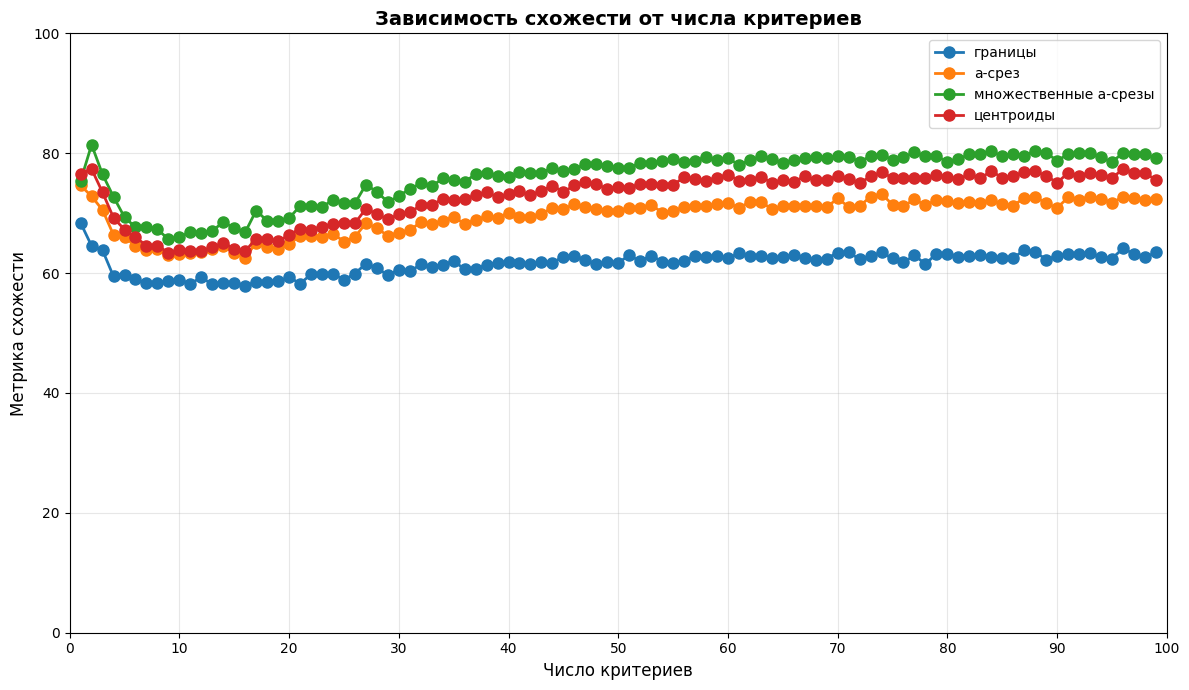

In [127]:
import matplotlib.pyplot as plt
trial_numbers = list(range(min_criteria, max_criteria))
methods = ['interval_simple', 'interval_ac', 'interval_wac', 'crisp']
method_labels = ['границы', 'a-срез', 'множественные a-срезы', 'центроиды']

plt.figure(figsize=(12, 7))

# Plot each method's values across trials
for method, label in zip(methods, method_labels):
    values = [d[method] for d in criteria_means]
    plt.plot(trial_numbers, values, marker='o', linewidth=2, markersize=8, label=label)

# Customize plot
plt.title('Зависимость схожести от числа критериев', fontsize=14, fontweight='bold')
plt.xlabel('Число критериев', fontsize=12)
plt.ylabel('Метрика схожести', fontsize=12)
plt.xticks([10 * i for i in range(11)])
plt.ylim(0, 100)
plt.xlim(0, 100)
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [128]:
import sys
alternative_means = []
min_alt = 2
max_alt = 100
experiment_iterations = 1000
for i in range(min_alt, max_alt):
    sys.stdout.write(f'\r{(i)/(max_alt - min_alt):.1%}')
    sys.stdout.flush()
    alternative_means.append(get_means(experiment_iterations, i, 10, with_output=False))
    

101.0%

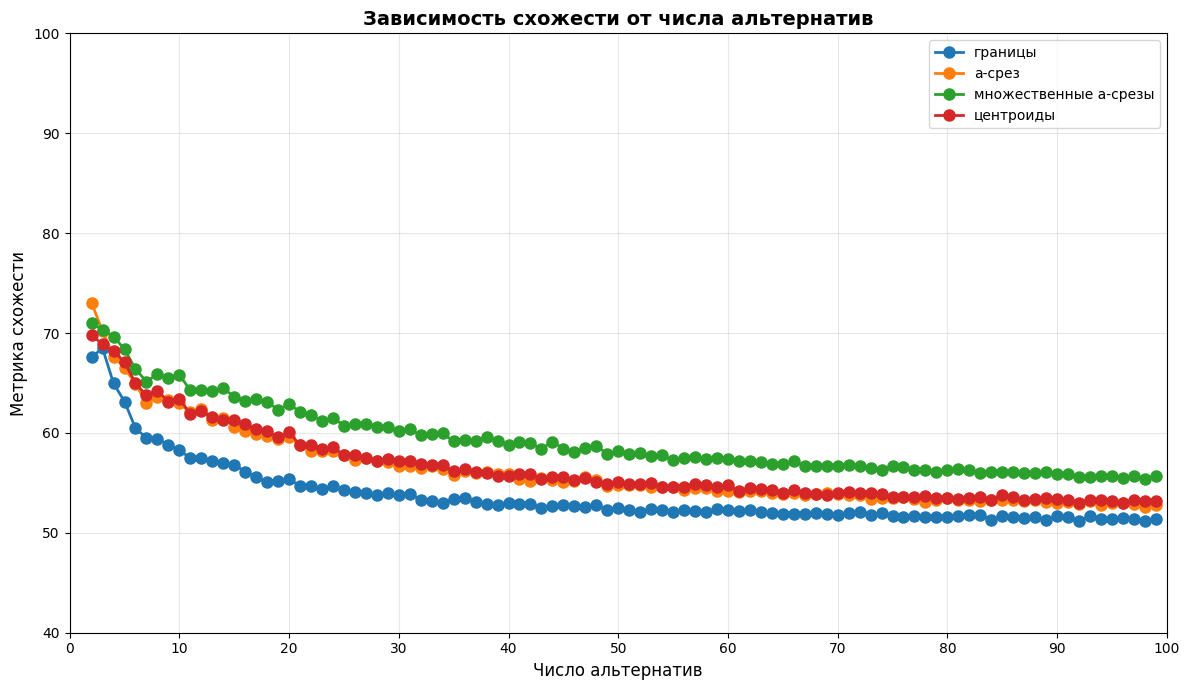

In [130]:
import matplotlib.pyplot as plt
trial_numbers = list(range(min_alt, max_alt))
methods = ['interval_simple', 'interval_ac', 'interval_wac', 'crisp']
method_labels = ['границы', 'a-срез', 'множественные a-срезы', 'центроиды']

plt.figure(figsize=(12, 7))

# Plot each method's values across trials
for method, label in zip(methods, method_labels):
    values = [d[method] for d in alternative_means]
    plt.plot(trial_numbers, values, marker='o', linewidth=2, markersize=8, label=label)

# Customize plot
plt.title('Зависимость схожести от числа альтернатив', fontsize=14, fontweight='bold')
plt.xlabel('Число альтернатив', fontsize=12)
plt.ylabel('Метрика схожести', fontsize=12)
plt.xticks([10 * i for i in range(11)])
plt.ylim(40, 100)
plt.xlim(0, 100)
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()